<a href="https://colab.research.google.com/github/dtabuena/Ephys_DataSets/blob/main/Analyze_BMX_HEK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter


'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None

"run dtabuena's ephys notebooks"
!git clone https://github.com/dtabuena/EphysLib
to_import = [
            'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            'Simple_ABF_tools.ipynb',
            'fun_math.ipynb',
            'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'Analyzers/input_resistance_analyzer.ipynb',
            'Analyzers/gain_analyzer.ipynb',
            'Analyzers/latencey_analyzer.ipynb',
            'Analyzers/IV_analyzer.ipynb',
            'Analyzers/Vm_analyzer.ipynb',
            'Analyzers/membrane_analyzer.ipynb',
            'Analyzers/rheobase_analyzer.ipynb',

            'Ephys_wrapper.ipynb',
            ]
for i in to_import:
    f = '/content/EphysLib/' + i
    %run $f




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 1.5 MB/s eta 0:00:00
Cloning into 'EphysLib'...
remote: Enumerating objects: 1141, done.
remote: Counting objects: 100% (519/519), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 1141 (delta 378), reused 357 (delta 269), pack-reused 622
Receiving objects: 100% (1141/1141), 17.41 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (754/754), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.4 MB/s eta 0:00:00


In [2]:
'https://www.dropbox.com/scl/fi/dnvbpjq6jhv9mvn23wrij/HEK-KCNT2.xlsx?rlkey=idsmjb0cc5fow087p190h0n6f&dl=1'

'https://www.dropbox.com/scl/fi/dnvbpjq6jhv9mvn23wrij/HEK-KCNT2.xlsx?rlkey=idsmjb0cc5fow087p190h0n6f&dl=1'

In [7]:
import urllib
file_name,_ = urllib.request.urlretrieve('https://www.dropbox.com/scl/fi/dnvbpjq6jhv9mvn23wrij/HEK-KCNT2.xlsx?rlkey=idsmjb0cc5fow087p190h0n6f&dl=1','before_after.xlsx')

In [8]:
dataset = {'data_name': 'BMX',
           'data_source': "https://www.dropbox.com/scl/fo/2ps1mdb88490cgol95l3u/h?rlkey=trp33s4fhrl4pyg4h4k0jecwh&dl=1",
           'file_naming_scheme': ['Rec_date','GenoType','Cell_num','Cell_Type'],
           }
##2023x12x13_SLICK_c001_HEK_0001
data_name = dataset['data_name']
data_source = dataset['data_source']
file_naming_scheme = dataset['file_naming_scheme']

''' Gather and Catalog Source Data'''
file_loc = get_drobox_folder_url(data_source, 'my_ephys_data_' + data_name)
clear_output(wait=False)
abf_recordings_df, protocol_set = catalogue_recs(file_loc,file_naming_scheme)
print(protocol_set)

['K_total_Run', 'VC - MemTest-10ms-160ms', 'K_total']


In [72]:
def measure_slick(abf,duration_ms = 10,to_plot=True):
    duration_ms = 10
    duration_indx = int(duration_ms/1000*abf.sampleRate)
    measure_epoch = get_epoch(abf,epoch=3)
    stop_idx = measure_epoch['index']["stop"]
    start_idx = stop_idx - duration_indx
    if 2 in abf.channelList: i_chan = 2
    else: i_chan = 0
    I,V,T = analyze_currents(abf,start_idx,stop_idx,i_chan=i_chan)
    return {'Ik':I,'Vm':V,'SweepTimes':T}

def get_epoch(abf,epoch=3):
    results={"epoch":epoch}
    results={"index":{"start":abf.sweepEpochs.p1s[epoch],
                      "stop":abf.sweepEpochs.p1s[epoch+1]}}
    return results

def analyze_currents(abf,start_idx,stop_idx,analysis_function=np.mean,i_chan=0,v_chan=1):
    I = list()
    V = list()
    for s in abf.sweepList:
        abf.setSweep(s,channel=i_chan)
        I.append(analysis_function(abf.sweepY[start_idx:stop_idx]))
        abf.setSweep(s,channel=v_chan)
        V.append(analysis_function(abf.sweepY[start_idx:stop_idx]))
    return I,V,list(abf.sweepTimesSec)


def linear_leak_correction(sweep_results,v_range=(-55,-10)):
    Vm = np.array(sweep_results['Vm'])[:,np.newaxis]
    I = np.array(sweep_results['Ik'])[:,np.newaxis]
    fit_ind = [i for i,v in enumerate(Vm) if v >= np.min(v_range) and v<= np.max(v_range) ]
    if len(fit_ind)<2:
        return dict()
    x = Vm[fit_ind]
    y = I[fit_ind]
    leak_model = linear_model.LinearRegression().fit(x,y)
    leak_pred  = leak_model.predict(Vm)
    corrected_I = I - leak_pred
    # plt.scatter(Vm,I,c='k')
    # plt.plot(Vm,leak_pred,'k')
    # plt.scatter(Vm,corrected_I,c='r')
    sweep_results['Ik_corr'] =corrected_I
    return sweep_results


In [73]:

abf_recordings_df

,Recording_name,cell_id,Rec_date,GenoType,Cell_num,Cell_Type,protocol,abf_timestamp,channelList,K_Currents
file_name,,,,,,,,,,
my_ephys_data_BMX/2023x12x13/2023x12x13_SLICK_c001_HEK_0001.abf,2023x12x13_SLICK_c001_HEK_0001.abf,2023x12x13_SLICK_c001_HEK,2023x12x13,SLICK,c001,HEK,K_total,2023-12-13T14:33:32.563,"[0, 1]","{'Ik': [-402.39874, -352.15454, -330.08423, -2..."
my_ephys_data_BMX/2023x12x13/2023x12x13_SLICK_c001_HEK_0002.abf,2023x12x13_SLICK_c001_HEK_0002.abf,2023x12x13_SLICK_c001_HEK,2023x12x13,SLICK,c001,HEK,K_total,2023-12-13T14:34:36.753,"[0, 1]","{'Ik': [-493.8477, -458.77692, -399.4263, -370..."
my_ephys_data_BMX/2023x12x13/2023x12x13_SLICK_c001_HEK_0003.abf,2023x12x13_SLICK_c001_HEK_0003.abf,2023x12x13_SLICK_c001_HEK,2023x12x13,SLICK,c001,HEK,K_total_Run,2023-12-13T14:38:07.605,"[0, 1]","{'Ik': [-101.78223, -115.90576, -114.489746, -..."
my_ephys_data_BMX/2023x12x13/2023x12x13_SLICK_c001_HEK_0004.abf,2023x12x13_SLICK_c001_HEK_0004.abf,2023x12x13_SLICK_c001_HEK,2023x12x13,SLICK,c001,HEK,K_total,2023-12-13T14:43:13.525,"[0, 1]","{'Ik': [-771.2342, -707.0861, -603.0212, -513...."
my_ephys_data_BMX/2023x12x13/2023x12x13_SLICK_c001_HEK_0005.abf,2023x12x13_SLICK_c001_HEK_0005.abf,2023x12x13_SLICK_c001_HEK,2023x12x13,SLICK,c001,HEK,K_total,2023-12-13T14:43:45.072,"[0, 1]","{'Ik': [-762.7502, -707.53784, -601.08026, -52..."
...,...,...,...,...,...,...,...,...,...,...
my_ephys_data_BMX/2023x12x18/2023x12x18_SLICK_c003_HEK_0001.abf,2023x12x18_SLICK_c003_HEK_0001.abf,2023x12x18_SLICK_c003_HEK,2023x12x18,SLICK,c003,HEK,K_total,2023-12-18T14:54:24.745,"[0, 1, 2]","{'Ik': [44.909668, 32.95288, 13.244629, 9.1735..."
my_ephys_data_BMX/2023x12x18/2023x12x18_SLICK_c003_HEK_0002.abf,2023x12x18_SLICK_c003_HEK_0002.abf,2023x12x18_SLICK_c003_HEK,2023x12x18,SLICK,c003,HEK,K_total,2023-12-18T14:55:34.008,"[0, 1]","{'Ik': [-2552.3926, -2327.0813, -2100.5188, -1..."
my_ephys_data_BMX/2023x12x18/2023x12x18_SLICK_c003_HEK_0003.abf,2023x12x18_SLICK_c003_HEK_0003.abf,2023x12x18_SLICK_c003_HEK,2023x12x18,SLICK,c003,HEK,K_total_Run,2023-12-18T14:55:50.748,"[0, 1, 2]","{'Ik': [376.40378, 388.80612, 417.88327, 368.4..."


In [69]:

abf_recordings_df.loc[rec]

Recording_name                   2023x12x15_SLICK_c001_HEK_0009.abf
cell_id                                   2023x12x15_SLICK_c001_HEK
Rec_date                                                 2023x12x15
GenoType                                                      SLICK
Cell_num                                                       c001
Cell_Type                                                       HEK
protocol                                                    K_total
abf_timestamp                               2023-12-15T10:49:36.674
channelList                                                  [0, 1]
K_Currents        {'Ik': [-725.2746, -666.0644], 'Vm': [-120.774...
Name: my_ephys_data_BMX/2023x12x15/2023x12x15_SLICK_c001_HEK_0009.abf, dtype: object

ValueError: ignored

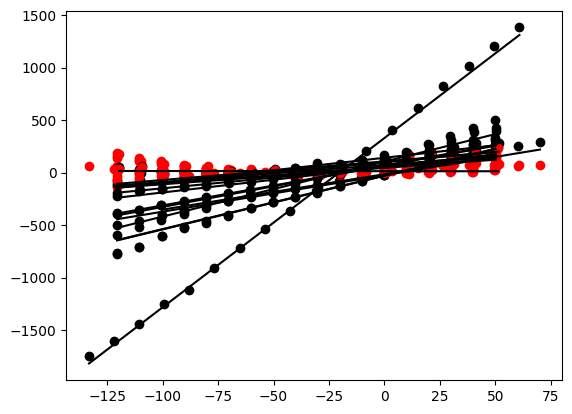

In [68]:
to_plot = True
results_list = list()
for rec in abf_recordings_df.index:
    abf = pyabf.ABF(rec)
    sweep_results = measure_slick(abf,duration_ms = 10,to_plot=True)
    if abf_recordings_df.loc[rec,'protocol'] == 'K_total':
        abf = pyabf.ABF(rec)
        sweep_results = linear_leak_correction(sweep_results)
    results_list.append(sweep_results)
abf_recordings_df['K_Currents']=results_list
abf_recordings_df

In [27]:
from sklearn import linear_model
v_range=(-45,-10)

In [56]:
#
abf = pyabf.ABF('my_ephys_data_BMX/2023x12x13/2023x12x13_SLICK_c001_HEK_0002.abf')
results = measure_slick(abf,duration_ms = 10,to_plot=True)

